# TP6: Action Classification via Recurrent models in Pytorch

**Authors:** 
- julien.denize@centralesupelec.fr
- tom.dupuis@centralesupelec.fr


If you have questions or suggestions, contact us and we will gladly answer and take into account your remarks.

For this tp you need to have some ground understanding of pytorch and basics introduction. It is available [here](https://pytorch.org/tutorials/beginner/basics/intro.html).




## Objective

In this TP, we will implement various Recurrent Models to make action classification for videos on the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php).

UCF101 is an action recognition data set of realistic action videos, collected from YouTube, having 101 action categories. This data set is an extension of UCF50 data set which has 50 action categories.

With 13320 videos from 101 action categories, UCF101 gives diversity in terms of actions and with the presence of large variations in camera motion, object appearance and pose, object scale, viewpoint, cluttered background, illumination conditions, etc, it was the most challenging data set few years ago. 

We will only use 20 classes from UCF101 to speed-up training.

We will extract frame features using a CNN backbone and make action classification on top of these features using various models:
- a custom LSTM model
- a RNN Pytorch model
- a LSTM Pytorch model
- a GRU Pytorch model

## Your task

Fill the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

In [ ]:
import torch
import numpy as np
import random

# Seed everything
seed=42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Retrieve the UCF101 dataset

### Download the UCF101 dataset frames from Kaggle

We will download the dataset from Kaggle. On Kaggle, UCF101 is stored as JPEG frames from each video clips.

Make sure to have correctly setup your drive following this procedure: https://www.kaggle.com/general/156610

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')
files.upload() #this will prompt you to upload the kaggle.json

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juliendenize","key":"898f147358a06d2094d871bd1e499fcc"}'}

The following cell will download the zip dataset containing all videos from the UCF101 dataset.

It should take around 1-2 minutes.

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d pevogam/ucf101-frames

-rw-r--r-- 1 root root 68 Oct 15 12:56 kaggle.json
100% 8.84G/8.85G [01:43<00:00, 158MB/s]
100% 8.85G/8.85G [01:44<00:00, 91.4MB/s]


The following cell only extract the 20 first classes of UCF101. Each frame from each video is located in its class folder.

It should take around 5 minutes.

In [ ]:
classes_to_extract = ["ApplyEyeMakeup", "ApplyLipstick", "Archery", 
                      "BabyCrawling", "BalanceBeam", "BandMarching", 
                      "BaseballPitch", "Basketball", "BasketballDunk", 
                      "BenchPress", "Biking", "Billiards", "BlowDryHair",
                      "BlowingCandles", "BodyWeightSquats", "Bowling", "BoxingPunchingBag",
                      "BoxingSpeedBag", "BreastStroke", "BrushingTeeth",]

idx_to_class = {i: class_ for i,class_ in enumerate(classes_to_extract)}

!mkdir ucf101
!mkdir ucf101/train
!mkdir ucf101/test

for class_ in classes_to_extract:
  !unzip ucf101-frames.zip "train/"{class_}"/*" -d "/content/ucf101/"
  !unzip ucf101-frames.zip "test/"{class_}"/*" -d "/content/ucf101/"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0227.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0228.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0229.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0230.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0231.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0232.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0233.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0234.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0235.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0236.jpg  
  inflating: /content/ucf101/test/BrushingTeeth/v_BrushingTeeth_g03_c01-0237.jpg  
  inflati

The following cell will store the name of each video associated to the number of frames and its label in a csv for the train and test splits.

In [ ]:
import os
import pandas as pd
import re
from pathlib import Path

classes_to_extract =  ["ApplyEyeMakeup", "ApplyLipstick", "Archery", 
                      "BabyCrawling", "BalanceBeam", "BandMarching", 
                      "BaseballPitch", "Basketball", "BasketballDunk", 
                      "BenchPress", "Biking", "Billiards", "BlowDryHair",
                      "BlowingCandles", "BodyWeightSquats", "Bowling", "BoxingPunchingBag",
                      "BoxingSpeedBag", "BreastStroke", "BrushingTeeth",]
idx_to_class = {i: class_ for i,class_ in enumerate(classes_to_extract)}

# Iterate over the train and test splits.
for split in ["train", "test"]:
  split_dir = f"/content/ucf101/{split}/"
  # dictionary to store dataframe data.
  split_dict = {"video": [], "class": [], "num_frames": []}
  for idx_class, class_ in enumerate(classes_to_extract):

    class_dir = f"{split_dir}{class_}/"

    # All frames for the class.
    files = [f for f in os.listdir(class_dir) if os.path.isfile(f"{class_dir}{f}")]

    # Pattern to retrieve the video name from a JPEG file.
    video_pattern = r"^.+\/(.+)-[\d]+\.jpg"

    videos = {}
    for f in files:
      path_file = f"{class_dir}{f}"
      match = re.search(video_pattern, path_file).group(1)
      
      if match in videos:
        videos[match] += 1
      else:
        videos[match] = 0
    
    for video, num_frames in videos.items():
      split_dict["video"].append(f"{class_}/{video}")
      split_dict["class"].append(idx_class)
      split_dict["num_frames"].append(num_frames)
  
  dataframe = pd.DataFrame.from_dict(split_dict)
  # Store in csv files.
  dataframe.to_csv(f"/content/ucf101/{split}.csv", index=False, header=False)       

## Make a dataset for the frames

In this section, we will implement a dataset that can read the data from our UCF101 dataset stored as frames thanks to the csv files previously created. A sample corresponds to a unique video. This means that getting from the dataset a speicifed index returns the whole video and not a specific frame of a video.

```python
dataset = FrameDataset(csv_file)
x, y = dataset[100] # returns the loaded frames of the whole video and its class.
```

Inside the frame dataset we need to transform the loaded image to first resize the shorter side to $256$ and then CenterCrop the image to a square image of $224 \times 224$. Finally the image should be cast to tensor.

In [ ]:
import torch
import pandas as pd
from typing import Any, Tuple
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class FrameDataset(Dataset):
  """
  Frame dataset from a CSV file that decode frames to fetch videos.

  Args:
    csv_file: the csv file that contains information about the dataset.
    video_path_prefix: the root folder of the videos.
  """

  def __init__(self, csv_file: str, video_path_prefix: str) -> None:
    super().__init__()
    self.video_path_prefix = Path(video_path_prefix)

    self._load_csv(csv_file)

  def _load_csv(self, csv_file: str) -> None:
    # --- START CODE HERE (01)
    # Read the csv file using the dataframe from pandas.
    dataframe = pd.read_csv(csv_file, header=None, index_col=False)
    # --- END CODE HERE
    self.data = dataframe

    # --- START CODE HERE (02)
    # Instantiate the transformation to apply on each image.
    self.transform = transforms.Compose((transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor()))
    # --- END CODE HERE
  
  def __getitem__(self, idx: int) -> Tuple[Any]:
      row = self.data.loc[idx]
      video_name, label, num_frames = row 

      frames = [None for _ in range(num_frames)]

      # Load all the frames of the video.
      for i in range(1, num_frames + 1):
        # --- START CODE HERE (03)
        # Load the frame and store it in the frames list as a tensor.
        path = self.video_path_prefix / f"{video_name}-{i:04d}.jpg"
        with open(path, "rb") as f:
          img = Image.open(f)
          frames[i - 1] = self.transform(img.convert("RGB"))
        # --- END CODE HERE
      
      frames = torch.stack(frames)

      return frames, label

  def __len__(self) -> int:
    return len(self.data)

dataset = FrameDataset("/content/ucf101/train.csv", "/content/ucf101/train/")
frames, label = dataset[0]
frames.shape, label # Should return (torch.Size([212, 3, 224, 224]), 0)

(torch.Size([169, 3, 224, 224]), 0)

### Visualize the videos

Below we provide code to visualize the data using matplotlib and animations sliding through all frames of videos.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from torch import Tensor

rc('animation', html='jshtml')

def display_video(video: Tensor) -> animation.ArtistAnimation:
  """
  Get the animation to display the video.

  Args:
    video: the video to display.

  Return:
    the slide show of for the video.
  """
  video = (video.permute((0, 2, 3, 1)) * 255.).long()
  fig, ax = plt.subplots()
  frames = [[ax.imshow(video[i])] for i in range(len(video))]
  ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  anim = animation.ArtistAnimation(fig,frames)
  plt.close()
  return anim

In [ ]:
anim = display_video(frames[:32]) # To prevent the notebook from failing don't display all frames
anim

## Extract the features of each video from a pretrained model

We will implement a feature extractor. To do so we need to:
- initialize a CNN 2D model with pretrained weights.
- iterate over the FrameDataset to extract features from each video for each frame.
- store the features to reuse them afterwards and not having to compute them everytime we reload the notebook (the extraction takes 30 minutes, don't worry we will provide you the saved extracted features).

### Retrieve the model

We will use the Resnet18 backbone to extract our features from torchvision with its ImageNet pretrained weights.

To extract features and not class predictions, we will replace the last fully connected layer by the identity.

In [ ]:
# --- START CODE HERE (04)
# Import the resnet model and the Identity module.
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn import Identity
# --- END CODE HERE

def get_pretrained_model(model_name: str = "resnet18"):
  if model_name == "resnet18":
    # --- START CODE HERE (05)
    # Instantiate the model and replace the last fully connected layer.
    model = resnet18(ResNet18_Weights.DEFAULT)
    model.fc = Identity()
    # --- END CODE HERE
  else:
    raise NotImplementedError(f"{model_name} is not supported.")

  return model

get_pretrained_model()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Feature extractor


You will now implement the feature extractor. We will concatenate the features of each video in one big tensor and output three different tensors:
- the features
- the labels
- the number of frames per video.

To store the features in one big tensor, we need to:
- retrieve the maximum number of frames across the dataset.
- for each video, extract the features of each image, stack the features and pad the features frame dimension to match the maximum number of frames.

In [ ]:
import torch
from torch.utils.data import Dataset
from torch import Tensor
from torch.nn import Module

@torch.no_grad()
def feature_extractor(dataset: FrameDataset, model: Module, device: str = "cpu") -> Tensor:
  """
  Extract the features from a video dataset.

  Args:
    dataset: The dataset to extract features from.
    model: The model to make the extraction.
    device: The device on which to perform extraction.
  
  Return:
    The features for each video along with the labels and the number of frames per video.
  """

  model.eval()

  features = [None for _ in range(len(dataset))]

  # --- START CODE HERE (06)
  # Retrieve the maximum number of frames and the padding number of frames to apply for each video.
  max_num_frames = dataset.data.iloc[:, -1].max()
  diff_num_frames = max_num_frames - dataset.data.iloc[:, -1]
  # --- END CODE HERE

  for i in range(len(dataset)):
    frames, y = dataset[i]
    
    if device == "cuda":
      frames = frames.cuda(non_blocking=True)
    
    # --- START CODE HERE (07)
    # Extract the frame features and pad if necessary new frames as zeros.
    features[i] = model(frames).cpu()
    if diff_num_frames[i] > 0:
      d = features[i].shape[1]
      features[i] = torch.cat((features[i], torch.zeros((diff_num_frames[i], d))))
    # --- END CODE HERE

    if i % 100 == 0:
      print(f"{i+1}/{len(dataset)} videos extracted.")
  
  features = torch.stack(features)
  labels = torch.tensor(dataset.data.iloc[:, -2])
  num_frames = torch.tensor(dataset.data.iloc[:, -1])
  
  return features, labels, num_frames

### [Optional] Extract the features

It takes around 35 minutes to extract all the features. We suggest you to retrieve them from our drive.

In [ ]:
train_frame_dataset = FrameDataset("/content/ucf101/train.csv", "/content/ucf101/train/")
test_frame_dataset = FrameDataset("/content/ucf101/test.csv", "/content/ucf101/test/")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_pretrained_model("resnet18").cuda()

train_features, train_labels, train_num_frames = feature_extractor(train_frame_dataset, model, device)
test_features, test_labels, test_num_frames = feature_extractor(test_frame_dataset, model, device)

1/1933 videos extracted.
101/1933 videos extracted.
201/1933 videos extracted.
301/1933 videos extracted.
401/1933 videos extracted.
501/1933 videos extracted.
601/1933 videos extracted.
701/1933 videos extracted.
801/1933 videos extracted.
901/1933 videos extracted.
1001/1933 videos extracted.
1101/1933 videos extracted.
1201/1933 videos extracted.
1301/1933 videos extracted.
1401/1933 videos extracted.
1501/1933 videos extracted.
1601/1933 videos extracted.
1701/1933 videos extracted.
1801/1933 videos extracted.
1901/1933 videos extracted.
1/761 videos extracted.
101/761 videos extracted.
201/761 videos extracted.
301/761 videos extracted.
401/761 videos extracted.
501/761 videos extracted.
601/761 videos extracted.
701/761 videos extracted.


### [Optional] Save the features

In [ ]:
del train_frame_dataset
del test_frame_dataset
del model

path_to_save_features = "/content/gdrive/MyDrive/COURS CS BDMA/Cours Deep Learning/Cours 6/features/"

In [ ]:
torch.save(train_features, f"{path_to_save_features}train_features.pt")
torch.save(train_labels, f"{path_to_save_features}train_labels.pt")
torch.save(train_num_frames, f"{path_to_save_features}train_num_frames.pt")

In [ ]:
torch.save(test_features, f"{path_to_save_features}test_features.pt")
torch.save(test_labels, f"{path_to_save_features}test_labels.pt")
torch.save(test_num_frames, f"{path_to_save_features}test_num_frames.pt")

## Make Dataset from extracted features

Now that we extracted the features from the dataset, we can now iterate over features data to perform training of various models, quicker than if we kept the different frames.

If you didn't extract the features yourself, you can find them from this google drive folder:

https://drive.google.com/drive/folders/1-35TDMEpv-J5ca7t45ZZ7nXSrVFshOZp?usp=sharing

### Make clip samplers

To make use of our data in different models, we need to provide sequence of the same length. For that we will implement two clip samplers:
- a random clip sampler that randomly subsample a sequence among the video.
- a middle clip sampler that select the sequence in the middle of the video.

In [ ]:
from torch import Tensor

def random_clip_sampler(features: Tensor, sequence_length: int = 32) -> Tensor:
  """
  Random clip sampler that randomly select a sub sequence in the video.
  
  Args:
    features: the video features to extract the sequence from. Shape T, C, H, W.
    sequence_length: the size of the sequence to extract.
  
  Return:
    The extracted sequence.
  """

  # --- START CODE HERE (08)
  # Compute max start sequence indice and sample randomly the start indice for the sequence.
  max_start_sequence = features.shape[0] - sequence_length
  start = random.randint(0, max_start_sequence)
  # --- END CODE HERE

  return features[start: start + sequence_length]

def middle_clip_sampler(features: Tensor, sequence_length: int = 32) -> Tensor:
  """
  Clip sampler that selects1 the middle sequence in the video.
  
  Args:
    features: the video features to extract the sequence from. Shape T, C, H, W.
    sequence_length: the size of the sequence to extract.
  
  Return:
    The extracted sequence.
  """

  # --- START CODE HERE (09)
  # Compute the start and the end indices of the sequence.
  start = (features.shape[0] - sequence_length) // 2
  end = (features.shape[0] + sequence_length) // 2
  # --- END CODE HERE

  return features[start:end]

### Instantiate Features datasets

We will implement a dataset that read from files the features, labels and num frames that we saved after extraction.

For that we will only keep videos that have enough number of frames given the sequence length we will provide (by default 32).

Then for each video the dataset returns the tuple of:
- the sequence features extracted from the clip sampler.
- the label of the video

In [ ]:
import torch
from typing import Any, Callable, Tuple
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class FeaturesDataset(Dataset):
  def __init__(self, root_folder: str, split: str, clip_sampler: Callable, sequence_length: int = 32) -> None:
    """
    Features dataset from several torch files that decode features for videos.

    Args:
      root_folder: the folder that contaiins the dataset.
      split: the split of the dataset. Either 'train' or 'test'.
      clip_sampler: the clip sampler to extract sequences from videos.
      sequence_length: sequence length for each clip.
    """
    super().__init__()
    self.features = torch.load(f"{root_folder}/{split}_features.pt")
    self.labels = torch.load(f"{root_folder}/{split}_labels.pt")
    self.num_frames = torch.load(f"{root_folder}/{split}_num_frames.pt")

    self.clip_sampler = clip_sampler
    self.sequence_length = sequence_length

    # --- START CODE HERE (09)
    # Only keep elements that have a number of frames larger than the sequence length.
    keep_indices = self.num_frames >= sequence_length
    self.features = self.features[keep_indices]
    self.labels = self.labels[keep_indices]
    self.num_frames = self.num_frames[keep_indices]
    # --- END CODE HERE
  
  def __getitem__(self, idx: int) -> Tuple[Any]:
    num_frames = self.num_frames[idx]
    label = self.labels[idx]
    
    # --- START CODE HERE (10)
    # Only keep frames that have not been padded and sample a clip.
    features = self.features[idx, :num_frames]
    features = self.clip_sampler(features, self.sequence_length)
    # --- END CODE HERE
    
    return features, label

  def __len__(self) -> int:
    return self.features.shape[0]

root_folder = "/content/gdrive/MyDrive/COURS CS BDMA/Cours Deep Learning/Cours 6/features/"

# To avoid RAM shortage we delete the train and test dataset before loading them again (if they were loaded).
try:
  del train_dataset
except NameError:
  pass

try: 
  test_dataset
except NameError:
  pass

train_dataset = FeaturesDataset(root_folder, "train", random_clip_sampler)
test_dataset = FeaturesDataset(root_folder, "test", middle_clip_sampler)
frames, label = train_dataset[0]
frames.shape, label # Should return (torch.Size([32, 512]), 0)

(torch.Size([32, 512]), tensor(0))

### Instantiate dataloaders

We instantiate the train and test dataloaders.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              pin_memory=device=="cuda", num_workers=1,
                              drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             pin_memory=device=="cuda", num_workers=1,
                             drop_last=False)

## Make the classification models

We will make action classification from three different models:
- a custom LSTM model.
- a RNN model.
- a LSTM model.
- a GRU model.

We expect to have the following performance order: RNN < LSTM < GRU.

However, due to the dataset size we don't observe a drastic difference between the methods. Still in average we should observe this performance order between the methods.

### Training loop

Below is defined the various functions to perform training already filled.

In [ ]:
import matplotlib.pyplot as plt

def display_losses_and_accuracies(train_loss, test_loss, train_accuracy, test_accuracy):
  """
  Display the training and testing loss and accuracies.

  Args:
    train_loss: the training loss list.
    test_loss: the testing loss list.
    train_accuracy: the training accuracy list.
    test_accuracy: the testing accuracy list.
  """

  plt.subplot(1,2,1)
  plt.plot(train_loss, 'r')
  plt.plot(test_loss, 'g--')
  plt.xlabel('# epoch')
  plt.ylabel('loss')
  plt.grid(True)

  plt.subplot(1,2,2)
  plt.plot(train_accuracy, 'r')
  plt.plot(test_accuracy, 'g--')
  plt.xlabel('# epoch')
  plt.ylabel('accuracy')
  plt.grid(True)
  plt.show()

def F_computeAccuracy(preds, y):
    """Compute the accuracy.
    
    Args:
      preds:
          predicted value by the MLP.
      y:
          ground-truth class to predict.
    
    Return:
      The accuracy.
    """
    
    m = y.shape[0]
    if preds.shape[1] == 1:
      hard_preds = (preds > 0.5).to(torch.int64)
    else:
      hard_preds = (torch.argmax(preds, 1)).to(torch.int64)
    return torch.sum(hard_preds==y) / m

In [ ]:
def training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs, device="cpu"):
  """
  Make the training loop.

  Args:
    model: the model to train.
    loss_fn: the loss to minimize.
    optimizer: the optimizer for the model.
    train_dataloader: the train dataloader.
    test_dataloader: the test dataloader.
    num_epochs: the number of epochs to train.
    device: the device to train on.
  
  Return:
    The accuracy and loss metrics.
  """

  train_loss_epoch, train_accuracy_epoch = [], []
  test_loss_epoch, test_accuracy_epoch = [], []

  for num_epoch in range(1, nb_epoch + 1):
    model.train()
    train_loss_iter, train_accuracy_iter = [], []
    test_loss_iter, test_accuracy_iter = [], []

    for batch_idx, batch in enumerate(train_dataloader):
      
      # --- Load train data
      X, y = batch
      if device == "cuda":
        X, y = X.cuda(non_blocking=True), y.cuda(non_blocking=True)
      
      # --- Forward
      train_preds = model(X)
      loss = loss_fn(train_preds, y)

      accuracy = F_computeAccuracy(train_preds, y)
      
      # --- Store results on train
      train_loss_iter.append(loss.item())
      train_accuracy_iter.append(accuracy)
      
      # --- Backward
      optimizer.zero_grad()
      loss.backward()
      
      # --- Update parameters
      optimizer.step()

    with torch.no_grad():
      model.eval()
      for batch_idx, batch in enumerate(test_dataloader):

        # --- Load test data
        X, y = batch
        if device == "cuda":
          X, y = X.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # --- Store results on test
        test_preds = model(X)
        loss = loss_fn(test_preds, y)
        accuracy = F_computeAccuracy(test_preds, y)
        test_loss_iter.append(loss.item())    
        test_accuracy_iter.append(accuracy)

    train_loss_epoch.append(torch.mean(torch.tensor(train_loss_iter)))  
    train_accuracy_epoch.append(torch.mean(torch.tensor(train_accuracy_iter)))  
    test_loss_epoch.append(torch.mean(torch.tensor(test_loss_iter)))  
    test_accuracy_epoch.append(torch.mean(torch.tensor(test_accuracy_iter)))  
    
    print("epoch: {0:d}/{1:d} (loss: train {2:.2f} test {3:.2f}) (accuracy: train {4:.2f} test {5:.2f})".format(num_epoch,
                                                                                                                nb_epoch,
                                                                                                                train_loss_epoch[-1],
                                                                                                                test_loss_epoch[-1],
                                                                                                                train_accuracy_epoch[-1],
                                                                                                                test_accuracy_epoch[-1]))

  return train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch

### Custom LSTM

We will implement a LSTM model. It is an improved version of a RNN that implements a memory mechanism to avoid vanishing gradient and loss of long-term dependencies. 

![](https://miro.medium.com/max/1100/0*VXNy36Ay_Rq3m1LE.png)

The forget gate equations are the following:

$f_t = \sigma(U_fx_t + V_fh_{t-1} + b_f)$

$C'_t = f_t \cdot C_{t-1}$

The memory gate equations are the following:

$i_t = \sigma(U_ix_t + V_ih_{t-1} + b_i)$

$g_t = tanh(U_cx_t+V_ch_{t-1}+b_c)$

$C_t = C_t' + i_t \cdot g_t$

The output gate equations are the following:

$o_t = \sigma(U_0x_t + V_0h_{t-1} + b_0)$

$h_t = o_t \cdot tanh(C_t)$


We will now implement a LSTM cell followed by a classifier with the following parameters:
- input dimension 512 (feature size of resnet18).
- hidden dimension 256.
- output dimension 20 (number of classes).
- the parameters W, U, bias will be only one big matrices that we will cut in pieces in forward of shape:
  - $W$: input dimension, hidden dimension * 4.
  - $U$: hidden dimension, hidden dimension * 4.
  - $bias$: hidden dimension * 4.
- a dropout layer after the LSTM cell of probability 0.8.
- a linear layer for classification.


In LSTM layers, all the hidden representations are in the output but because we only want to perform classification on the last state, we won't bother with that functionality.

You should reach around 73-75 % test accuracy.

In [ ]:
import torch
from torch import nn
from torch.nn import Dropout, Linear
import math

class CustomLSTMModel(nn.Module):
    """
    Custom LSTM model.

    Args:
      input_dim: the input dimension.
      hidden_dim: the hidden dimension.
      output_dim: the output dimension.
    """
    def __init__(self, input_dim: int = 512, hidden_dim: int = 256, output_dim: int = 20):
        super().__init__()
        self.input_dim = hidden_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # --- START CODE HERE (11)
        # Instantiate the W, U, bias matrice parameters aswell as the dropout and linear layers.
        self.W = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))

        self.dropout = Dropout(0.8)
        self.fc = Linear(self.hidden_dim, self.output_dim)
        # --- END CODE HERE
  
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x):
        """Assumes x is of shape (batch, sequence, feature)"""

        batch_size, sequence_length, _ = x.shape

        # --- START CODE HERE (12)
        # Initalize h_t and c_t hidden states to zero tensors.
        h_t, c_t = (torch.zeros(batch_size, self.hidden_dim).to(x.device), 
                    torch.zeros(batch_size, self.hidden_dim).to(x.device))
        # --- END CODE HERE
         
        self.hidden_dim
        for t in range(sequence_length):
            x_t = x[:, t, :]

            # --- START CODE HERE (13)
            # Follow the LSTM equations

            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias

            i_t = torch.sigmoid(gates[:, :self.hidden_dim]) # i_t input gate
            f_t = torch.sigmoid(gates[:, self.hidden_dim:self.hidden_dim*2]) # f_t forget gate
            g_t = torch.tanh(gates[:, self.hidden_dim*2:self.hidden_dim*3]) # g_t
            o_t = torch.sigmoid(gates[:, self.hidden_dim*3:]) # o_t output gate
            
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            # --- END CODE HERE
        
        # --- START CODE HERE (14)
        # Apply the dropout and the classifier.
        output = self.dropout(h_t)
        output = self.fc(output)
        # --- END CODE HERE

        return output

CustomLSTMModel()

CustomLSTMModel(
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=256, out_features=20, bias=True)
)

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# Run over epochs
nb_epoch = 50

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CustomLSTMModel().to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_fn = CrossEntropyLoss().to(device)

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch, device)

epoch: 1/50 (loss: train 3.04 test 2.97) (accuracy: train 0.05 test 0.07)
epoch: 2/50 (loss: train 2.94 test 2.88) (accuracy: train 0.09 test 0.24)
epoch: 3/50 (loss: train 2.84 test 2.77) (accuracy: train 0.16 test 0.33)
epoch: 4/50 (loss: train 2.69 test 2.62) (accuracy: train 0.23 test 0.40)
epoch: 5/50 (loss: train 2.54 test 2.43) (accuracy: train 0.28 test 0.43)
epoch: 6/50 (loss: train 2.36 test 2.22) (accuracy: train 0.36 test 0.46)
epoch: 7/50 (loss: train 2.14 test 2.02) (accuracy: train 0.39 test 0.48)
epoch: 8/50 (loss: train 1.96 test 1.83) (accuracy: train 0.44 test 0.52)
epoch: 9/50 (loss: train 1.78 test 1.64) (accuracy: train 0.49 test 0.58)
epoch: 10/50 (loss: train 1.59 test 1.49) (accuracy: train 0.54 test 0.62)
epoch: 11/50 (loss: train 1.49 test 1.36) (accuracy: train 0.56 test 0.63)
epoch: 12/50 (loss: train 1.38 test 1.29) (accuracy: train 0.58 test 0.65)
epoch: 13/50 (loss: train 1.27 test 1.26) (accuracy: train 0.63 test 0.63)
epoch: 14/50 (loss: train 1.20 tes

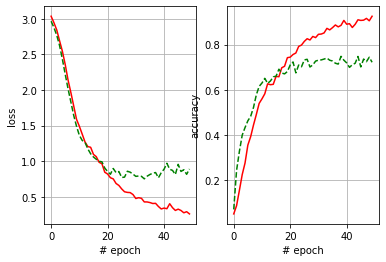

In [ ]:
display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

### RNN on top of the Features

We will implement a RNN Model based on the pytorch [RNN layer](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html).

![](https://miro.medium.com/max/640/1*m8ATMpOZI5ttTjoWWXt4Lg.png)

We will make use of the following layers:
- a RNN layer with batch first parameter.
- a Dropout layer of probability 0.8.
- a linear classifier to make classifications.

For the RNN layer, as the documentation states, we need to instantiate an initial hidden state. We will instantiate it to zero.

You should reach 71-73% test accuracy.

In [ ]:
from torch.nn import Dropout, Linear, Module, RNN
from torch import nn

class RNNModel(Module):
    """
    RNN model.

    Args:
      input_dim: the input dimension.
      output_dim: the output dimension.
      hidden_dim: the hidden dimension.
      n_layers: number of RNN layers stacked.
    """
    def __init__(self, input_dim: int = 512, output_dim: int = 20, hidden_dim: int = 512, n_layers: int = 1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers

        # --- START CODE HERE (15)
        # Instantiate the RNN, dropout and linear layers.
        self.rnn = RNN(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.dropout = Dropout(0.8)
        self.fc = Linear(self.hidden_dim, self.output_dim)
        # --- END CODE HERE

    def forward(self, x):
        """Assumes x is of shape (batch, sequence, feature)"""
        batch_size = x.shape[0]        

        # --- START CODE HERE (16)
        # Initiliaze the hidden state to a zero tensor for the RNN layer.
        # Retrieve last hidden state to apply dropout and linear classifier on.
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        r_out, h_n = self.rnn(x, h_0)
        h_n = h_n[-1]
        output = self.dropout(h_n)
        output = self.fc(output)
        # --- END CODE HERE
        return output

RNNModel()

RNNModel(
  (rnn): RNN(512, 512, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=512, out_features=20, bias=True)
)

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss


# Run over epochs
nb_epoch = 50

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNNModel().to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_fn = CrossEntropyLoss().to(device)

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch, device)

epoch: 1/50 (loss: train 3.09 test 2.78) (accuracy: train 0.08 test 0.21)
epoch: 2/50 (loss: train 2.70 test 2.36) (accuracy: train 0.19 test 0.45)
epoch: 3/50 (loss: train 2.18 test 1.93) (accuracy: train 0.37 test 0.51)
epoch: 4/50 (loss: train 1.79 test 1.61) (accuracy: train 0.49 test 0.57)
epoch: 5/50 (loss: train 1.44 test 1.39) (accuracy: train 0.59 test 0.62)
epoch: 6/50 (loss: train 1.24 test 1.23) (accuracy: train 0.63 test 0.63)
epoch: 7/50 (loss: train 1.07 test 1.16) (accuracy: train 0.68 test 0.63)
epoch: 8/50 (loss: train 0.91 test 1.05) (accuracy: train 0.75 test 0.66)
epoch: 9/50 (loss: train 0.83 test 0.99) (accuracy: train 0.76 test 0.67)
epoch: 10/50 (loss: train 0.75 test 0.97) (accuracy: train 0.76 test 0.67)
epoch: 11/50 (loss: train 0.67 test 0.94) (accuracy: train 0.80 test 0.68)
epoch: 12/50 (loss: train 0.61 test 0.92) (accuracy: train 0.81 test 0.69)
epoch: 13/50 (loss: train 0.58 test 0.89) (accuracy: train 0.82 test 0.71)
epoch: 14/50 (loss: train 0.49 tes

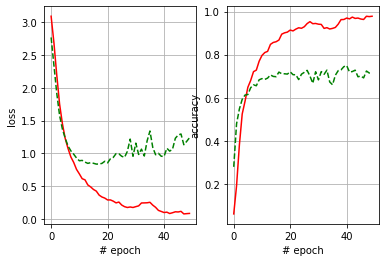

In [ ]:
display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

### Pytorch LSTM

We will implement a LSTM Model based on the pytorch [LSTM layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

We will make use of the following layers:
- a LSTM layer with batch first parameter.
- a Dropout layer of probability 0.8.
- a linear classifier to make classifications.

For the LSTM layer, as the documentation states, we need to instantiate an initial hidden state and an initial cell state. We will instantiate them to zero.

You should reach 73-75% test accuracy.

In [ ]:
from torch.nn import Dropout, LSTM, Linear
from torch import nn

class LSTMModel(Module):
    """
    LSTM model.

    Args:
      input_dim: the input dimension.
      output_dim: the output dimension.
      hidden_dim: the hidden dimension.
      n_layers: number of RNN layers stacked.
    """
    def __init__(self, input_dim: int = 512, output_dim: int = 20, hidden_dim: int = 256, n_layers: int = 1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        # --- START CODE HERE (17)
        # Instantiate the LSTM, dropout and linear layers.
        self.lstm = LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.dropout = Dropout(0.8)
        self.fc = Linear(self.hidden_dim, self.output_dim)
        # --- END CODE HERE

    def forward(self, x):
        """Assumes x is of shape (batch, sequence, feature)"""
        batch_size = x.size(0)

        # --- START CODE HERE (18)
        # Initiliaze the hidden and cell state to zero tensors for the LSTM layer.
        # Retrieve last hidden state to apply dropout and linear classifier on.
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        
        r_out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n = h_n[-1]
        
        output = self.dropout(h_n)
        output = self.fc(output)
        # --- END CODE HERE
        
        return output
    
LSTMModel()

LSTMModel(
  (lstm): LSTM(512, 256, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=256, out_features=20, bias=True)
)

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# Run over epochs
nb_epoch = 50

device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel().to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_fn = CrossEntropyLoss().to(device)

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch, device)

epoch: 1/50 (loss: train 3.02 test 2.94) (accuracy: train 0.06 test 0.12)
epoch: 2/50 (loss: train 2.93 test 2.84) (accuracy: train 0.09 test 0.26)
epoch: 3/50 (loss: train 2.81 test 2.72) (accuracy: train 0.16 test 0.34)
epoch: 4/50 (loss: train 2.66 test 2.56) (accuracy: train 0.24 test 0.39)
epoch: 5/50 (loss: train 2.48 test 2.37) (accuracy: train 0.31 test 0.44)
epoch: 6/50 (loss: train 2.28 test 2.15) (accuracy: train 0.36 test 0.48)
epoch: 7/50 (loss: train 2.10 test 1.94) (accuracy: train 0.39 test 0.49)
epoch: 8/50 (loss: train 1.89 test 1.75) (accuracy: train 0.46 test 0.55)
epoch: 9/50 (loss: train 1.72 test 1.58) (accuracy: train 0.51 test 0.58)
epoch: 10/50 (loss: train 1.57 test 1.43) (accuracy: train 0.53 test 0.60)
epoch: 11/50 (loss: train 1.40 test 1.31) (accuracy: train 0.58 test 0.62)
epoch: 12/50 (loss: train 1.30 test 1.26) (accuracy: train 0.61 test 0.58)
epoch: 13/50 (loss: train 1.20 test 1.16) (accuracy: train 0.64 test 0.64)
epoch: 14/50 (loss: train 1.09 tes

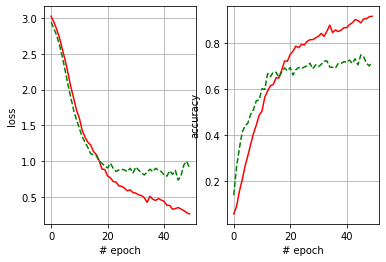

In [ ]:
display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

### GRU Model

We will implement a GRU Model based on the pytorch [GRU layer](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) that is supposed to be better or equivalent to LSTM.

![](https://blog.floydhub.com/content/images/2019/07/image14.jpg)

We will make use of the following layers:
- a GRU layer with batch first parameter.
- a Dropout layer of probability 0.8.
- a linear classifier to make classifications.

For the GRU layer, as the documentation states, we need to instantiate an initial hidden state. We will instantiate it to zero.

You should reach 75-77% test accuracy.

In [ ]:
from torch.nn import Dropout, Linear, Module, GRU
from torch import nn

class GRUModel(Module):
    """
    GRU model.

    Args:
      input_dim: the input dimension.
      output_dim: the output dimension.
      hidden_dim: the hidden dimension.
      n_layers: number of RNN layers stacked.
    """
    def __init__(self, input_dim: int = 512, output_dim: int = 20, hidden_dim: int = 512, n_layers: int = 1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers

        # --- START CODE HERE (19)
        # Instantiate the GRU, dropout and linear layers.
        self.rnn = GRU(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.dropout = Dropout(0.8)
        self.fc = Linear(self.hidden_dim, self.output_dim)
        # --- END CODE HERE

    def forward(self, x):
        """Assumes x is of shape (batch, sequence, feature)"""
        batch_size = x.shape[0]        

        # --- START CODE HERE (20)
        # Initiliaze the hidden state to a zero tensor for the GRU layer.
        # Retrieve last hidden state to apply dropout and linear classifier on.
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        r_out, h_n = self.rnn(x, h_0)
        h_n = h_n[-1]
        output = self.dropout(h_n)
        output = self.fc(output)
        # --- END CODE HERE
        
        return output

RNNModel()

RNNModel(
  (rnn): RNN(512, 512, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=512, out_features=20, bias=True)
)

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# Run over epochs
nb_epoch = 50

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GRUModel().to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_fn = CrossEntropyLoss().to(device)

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch, device)

epoch: 1/50 (loss: train 3.06 test 2.77) (accuracy: train 0.07 test 0.21)
epoch: 2/50 (loss: train 2.72 test 2.41) (accuracy: train 0.19 test 0.42)
epoch: 3/50 (loss: train 2.31 test 2.06) (accuracy: train 0.34 test 0.54)
epoch: 4/50 (loss: train 1.95 test 1.78) (accuracy: train 0.48 test 0.57)
epoch: 5/50 (loss: train 1.67 test 1.57) (accuracy: train 0.55 test 0.62)
epoch: 6/50 (loss: train 1.45 test 1.41) (accuracy: train 0.62 test 0.63)
epoch: 7/50 (loss: train 1.27 test 1.28) (accuracy: train 0.66 test 0.64)
epoch: 8/50 (loss: train 1.14 test 1.20) (accuracy: train 0.69 test 0.65)
epoch: 9/50 (loss: train 1.04 test 1.13) (accuracy: train 0.72 test 0.66)
epoch: 10/50 (loss: train 0.97 test 1.08) (accuracy: train 0.72 test 0.67)
epoch: 11/50 (loss: train 0.89 test 1.03) (accuracy: train 0.77 test 0.68)
epoch: 12/50 (loss: train 0.82 test 0.99) (accuracy: train 0.77 test 0.69)
epoch: 13/50 (loss: train 0.75 test 0.96) (accuracy: train 0.80 test 0.70)
epoch: 14/50 (loss: train 0.72 tes

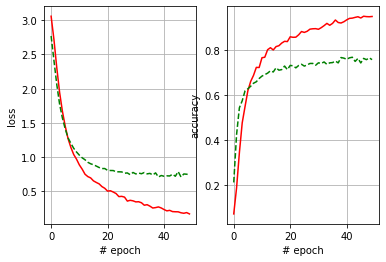

In [ ]:
display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

## BONUS

To improve your results you can try various things:
- Use another feature extractor:
  - Resnet34, Resnet50, ...
  - VGG.
  - DenseNet.
  - ...
- Change hyper-parameters for RNN, LSTM, GRU layers:
  - use several layers.
  - try bidirectional parameter.
  - increase the hidden dimension.
- Change the optimizer parameters.
- Use shorter or larger clip sequences.
- Try to use 3D networks instead of Recurent networks such as ResNet3D , or S3D.
- Try to use attention based networks.
- ...
